# MNIST Image Classification with TensorFlow on Vertex AI

This notebook demonstrates how to implement different image models on MNIST using the [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras).

## Learning Objectives
1. Understand how to build a Dense Neural Network (DNN) for image classification
2. Understand how to use dropout (DNN) for image classification
3. Understand how to use Convolutional Neural Networks (CNN)
4. Know how to deploy and use an image classifcation model using Google Cloud's [Vertex AI](https://cloud.google.com/vertex-ai/)

First things first. Configure the parameters below to match your own Google Cloud project details.

In [1]:
import os
from datetime import datetime

REGION = "us-central1"
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT
MODEL_TYPE = "cnn"  # "linear", "dnn", "dnn_dropout", or "cnn"

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["MODEL_TYPE"] = MODEL_TYPE

## Building a dynamic model

In the previous notebook, <a href="mnist_linear.ipynb">mnist_linear.ipynb</a>, we ran our code directly from the notebook. In order to run it on Vertex AI, it needs to be packaged as a python module.

The boilerplate structure for this module has already been set up in the folder `mnist_models`. The module lives in the sub-folder, `trainer`, and is designated as a python package with the empty `__init__.py` (`mnist_models/trainer/__init__.py`) file. It still needs the model and a trainer to run it, so let's make them.

Let's start with the trainer file first. This file parses command line arguments to feed into the model.

In [2]:
%%writefile mnist_models/trainer/task.py
import argparse
import json
import os
import sys

from . import model


def _parse_arguments(argv):
    """Parses command-line arguments."""
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--model_type',
        help='Which model type to use',
        type=str, default='linear')
    parser.add_argument(
        '--epochs',
        help='The number of epochs to train',
        type=int, default=10)
    parser.add_argument(
        '--steps_per_epoch',
        help='The number of steps per epoch to train',
        type=int, default=100)
    parser.add_argument(
        '--job-dir',
        help='Directory where to save the given model',
        type=str, default='mnist_models/')
    return parser.parse_known_args(argv)


def main():
    """Parses command line arguments and kicks off model training."""
    args = _parse_arguments(sys.argv[1:])[0]

    # Configure path for hyperparameter tuning.
    trial_id = json.loads(
        os.environ.get('TF_CONFIG', '{}')).get('task', {}).get('trial', '')
    output_path = args.job_dir if not trial_id else args.job_dir + '/'

    model_layers = model.get_layers(args.model_type)
    image_model = model.build_model(model_layers, args.job_dir)
    model_history = model.train_and_evaluate(
        image_model, args.epochs, args.steps_per_epoch, args.job_dir)


if __name__ == '__main__':
    main()


Writing mnist_models/trainer/task.py


Next, let's group non-model functions into a util file to keep the model file simple. We'll copy over the `scale` and `load_dataset` functions from the previous lab.

In [3]:
%%writefile mnist_models/trainer/util.py
import tensorflow as tf


def scale(image, label):
    """Scales images from a 0-255 int range to a 0-1 float range"""
    image = tf.cast(image, tf.float32)
    image /= 255
    image = tf.expand_dims(image, -1)
    return image, label


def load_dataset(
        data, training=True, buffer_size=5000, batch_size=100, nclasses=10):
    """Loads MNIST dataset into a tf.data.Dataset"""
    (x_train, y_train), (x_test, y_test) = data
    x = x_train if training else x_test
    y = y_train if training else y_test
    # One-hot encode the classes
    y = tf.keras.utils.to_categorical(y, nclasses)
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(scale).batch(batch_size)
    if training:
        dataset = dataset.shuffle(buffer_size).repeat()
    return dataset


Writing mnist_models/trainer/util.py


Finally, let's code the models! The [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras) accepts an array of [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) into a [model object](https://www.tensorflow.org/api_docs/python/tf/keras/Model), so we can create a dictionary of layers based on the different model types we want to use. The below file has two functions: `get_layers` and `create_and_train_model`. We will build the structure of our model in `get_layers`. Last but not least, we'll copy over the training code from the previous lab into `train_and_evaluate`.

**TODO 1**: Define the Keras layers for a DNN model   
**TODO 2**: Define the Keras layers for a dropout model  
**TODO 3**: Define the Keras layers for a CNN model  

Hint: These models progressively build on each other. Look at the imported `tensorflow.keras.layers` modules and the default values for the variables defined in `get_layers` for guidance.

In [10]:
%%writefile mnist_models/trainer/model.py
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)

from . import util


# Image Variables
WIDTH = 28
HEIGHT = 28


def get_layers(
        model_type,
        nclasses=10,
        hidden_layer_1_neurons=400,
        hidden_layer_2_neurons=100,
        dropout_rate=0.25,
        num_filters_1=64,
        kernel_size_1=3,
        pooling_size_1=2,
        num_filters_2=32,
        kernel_size_2=3,
        pooling_size_2=2):
    """Constructs layers for a keras model based on a dict of model types."""
    model_layers = {
        'linear': [
            Flatten(),
            Dense(nclasses),
            Softmax()
        ],
        'dnn': [
            # TODO
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dense(nclasses),
            Softmax()
        ],
        'dnn_dropout': [
            # TODO
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ],
        'cnn': [
            # TODO
            Conv2D(num_filters_1, kernel_size=kernel_size_1, activation='relu', input_shape=(WIDTH, HEIGHT, 1)),
            MaxPooling2D(pooling_size_1),
            Conv2D(num_filters_2, kernel_size=kernel_size_2, activation='relu'),
            MaxPooling2D(pooling_size_2),
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ]
    }
    return model_layers[model_type]


def build_model(layers, output_dir):
    """Compiles keras model for image classification."""
    model = Sequential(layers)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def train_and_evaluate(model, num_epochs, steps_per_epoch, output_dir):
    """Compiles keras model and loads data into it for training."""
    mnist = tf.keras.datasets.mnist.load_data()
    train_data = util.load_dataset(mnist)
    validation_data = util.load_dataset(mnist, training=False)

    callbacks = []
    if output_dir:
        tensorboard_callback = TensorBoard(log_dir=output_dir)
        callbacks = [tensorboard_callback]

    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        verbose=2,
        callbacks=callbacks)

    if output_dir:
        export_path = os.path.join(output_dir, 'keras_export')
        model.save(export_path, save_format='tf')

    return history


Overwriting mnist_models/trainer/model.py


## Local Training

With everything set up, let's run locally to test the code. Some of the previous tests have been copied over into a testing script `mnist_models/trainer/test.py` to make sure the model still passes our previous checks. On `line 13`, you can specify which model types you would like to check. `line 14` and `line 15` has the number of epochs and steps per epoch respectively.

Moment of truth! Run the code below to check your models against the unit tests. If you see "OK" at the end when it's finished running, congrats! You've passed the tests!

In [7]:
!python3 -m mnist_models.trainer.test

/opt/conda/bin/python3: No module named mnist_models.trainer.test


Now that we know that our models are working as expected, let's run it on Google Cloud within Vertex AI. We can run it as a python module locally first using the command line.

The below cell transfers some of our variables to the command line as well as create a job directory including a timestamp.

In [53]:
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
model_type = "cnn"

os.environ["MODEL_TYPE"] = model_type
os.environ["JOB_DIR"] = "mnist_models/models/{}_{}/".format(
    model_type, current_time
)

The cell below runs the local version of the code. The epochs and steps_per_epoch flag can be changed to run for longer or shorther, as defined in our `mnist_models/trainer/task.py` file.

In [55]:
%%bash
python3 -m mnist_models.trainer.task \
    --job-dir=$JOB_DIR \
    --epochs=10 \
    --steps_per_epoch=100 \
    --model_type=$MODEL_TYPE

Epoch 1/10
100/100 - 15s - loss: 0.6636 - accuracy: 0.7961 - val_loss: 0.1834 - val_accuracy: 0.9457 - 15s/epoch - 147ms/step
Epoch 2/10
100/100 - 10s - loss: 0.1892 - accuracy: 0.9430 - val_loss: 0.0982 - val_accuracy: 0.9690 - 10s/epoch - 96ms/step
Epoch 3/10
100/100 - 9s - loss: 0.1378 - accuracy: 0.9573 - val_loss: 0.0955 - val_accuracy: 0.9685 - 9s/epoch - 87ms/step
Epoch 4/10
100/100 - 9s - loss: 0.1078 - accuracy: 0.9676 - val_loss: 0.0645 - val_accuracy: 0.9784 - 9s/epoch - 88ms/step
Epoch 5/10
100/100 - 9s - loss: 0.0915 - accuracy: 0.9721 - val_loss: 0.0521 - val_accuracy: 0.9831 - 9s/epoch - 86ms/step
Epoch 6/10
100/100 - 9s - loss: 0.0819 - accuracy: 0.9746 - val_loss: 0.0513 - val_accuracy: 0.9829 - 9s/epoch - 86ms/step
Epoch 7/10
100/100 - 10s - loss: 0.0728 - accuracy: 0.9776 - val_loss: 0.0405 - val_accuracy: 0.9872 - 10s/epoch - 100ms/step
Epoch 8/10
100/100 - 9s - loss: 0.0584 - accuracy: 0.9839 - val_loss: 0.0391 - val_accuracy: 0.9883 - 9s/epoch - 86ms/step
Epoch 9/

2022-07-19 17:37:23.137545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-07-19 17:37:23.137605: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-19 17:37:23.137633: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hurb-asl): /proc/driver/nvidia/version does not exist
2022-07-19 17:37:23.138065: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-19 17:39:4

## Training on the cloud

For this model, we will be able to use a Tensorflow pre-built container on Vertex AI, as we do not have any particular additional prerequisites. As before, we use `setuptools` for this, and store the created source distribution on Cloud Storage.

In [13]:
%%writefile mnist_models/setup.py
from setuptools import find_packages
from setuptools import setup

setup(
    name='mnist_trainer',
    version='0.1',
    packages=find_packages(),
    include_package_data=True,
    description='MNIST model training application.'
)

Writing mnist_models/setup.py


In [14]:
%%bash
cd mnist_models
python ./setup.py sdist --formats=gztar
cd ..
gsutil cp mnist_models/dist/mnist_trainer-0.1.tar.gz gs://${BUCKET}/mnist/

running sdist
running egg_info
creating mnist_trainer.egg-info
writing mnist_trainer.egg-info/PKG-INFO
writing dependency_links to mnist_trainer.egg-info/dependency_links.txt
writing top-level names to mnist_trainer.egg-info/top_level.txt
writing manifest file 'mnist_trainer.egg-info/SOURCES.txt'
reading manifest file 'mnist_trainer.egg-info/SOURCES.txt'
writing manifest file 'mnist_trainer.egg-info/SOURCES.txt'
running check
creating mnist_trainer-0.1
creating mnist_trainer-0.1/mnist_trainer.egg-info
creating mnist_trainer-0.1/trainer
copying files to mnist_trainer-0.1...
copying setup.py -> mnist_trainer-0.1
copying mnist_trainer.egg-info/PKG-INFO -> mnist_trainer-0.1/mnist_trainer.egg-info
copying mnist_trainer.egg-info/SOURCES.txt -> mnist_trainer-0.1/mnist_trainer.egg-info
copying mnist_trainer.egg-info/dependency_links.txt -> mnist_trainer-0.1/mnist_trainer.egg-info
copying mnist_trainer.egg-info/top_level.txt -> mnist_trainer-0.1/mnist_trainer.egg-info
copying trainer/__init__.p




Copying file://mnist_models/dist/mnist_trainer-0.1.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  2.4 KiB/  2.4 KiB]                                                
Operation completed over 1 objects/2.4 KiB.                                      


Then, we can kickoff the Vertex AI Custom Job using the pre-built container. We can pass our source distribution URI using the `--python-package-uris` flag.

In [15]:
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
model_type = "cnn"

os.environ["MODEL_TYPE"] = model_type
os.environ["JOB_DIR"] = "gs://{}/mnist_{}_{}/".format(
    BUCKET, model_type, current_time
)
os.environ["JOB_NAME"] = f"mnist_{model_type}_{current_time}"

In [16]:
%%bash
echo $JOB_DIR $REGION $JOB_NAME

PYTHON_PACKAGE_URIS=gs://${BUCKET}/mnist/mnist_trainer-0.1.tar.gz
MACHINE_TYPE=n1-standard-4
REPLICA_COUNT=1
PYTHON_PACKAGE_EXECUTOR_IMAGE_URI="us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-3:latest"
PYTHON_MODULE=trainer.task
    
WORKER_POOL_SPEC="machine-type=$MACHINE_TYPE,\
replica-count=$REPLICA_COUNT,\
executor-image-uri=$PYTHON_PACKAGE_EXECUTOR_IMAGE_URI,\
python-module=$PYTHON_MODULE"

gcloud ai custom-jobs create \
  --region=${REGION} \
  --display-name=$JOB_NAME \
  --python-package-uris=$PYTHON_PACKAGE_URIS \
  --worker-pool-spec=$WORKER_POOL_SPEC \
  --args="--job-dir=$JOB_DIR,--model_type=$MODEL_TYPE"

gs://qwiklabs-asl-03-5d5c0ba6f6d6/mnist_cnn_20220719_170044/ us-central1 mnist_cnn_20220719_170044


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
CustomJob [projects/464686547413/locations/us-central1/customJobs/2110915265649704960] is submitted successfully.

Your job is still active. You may view the status of your job with the command

  $ gcloud ai custom-jobs describe projects/464686547413/locations/us-central1/customJobs/2110915265649704960

or continue streaming the logs with the command

  $ gcloud ai custom-jobs stream-logs projects/464686547413/locations/us-central1/customJobs/2110915265649704960


In [24]:
%%bash
gcloud ai custom-jobs describe projects/464686547413/locations/us-central1/customJobs/2110915265649704960

createTime: '2022-07-19T17:00:51.192113Z'
displayName: mnist_cnn_20220719_170044
jobSpec:
  workerPoolSpecs:
  - diskSpec:
      bootDiskSizeGb: 100
      bootDiskType: pd-ssd
    machineSpec:
      machineType: n1-standard-4
    pythonPackageSpec:
      args:
      - --job-dir=gs://qwiklabs-asl-03-5d5c0ba6f6d6/mnist_cnn_20220719_170044/
      - --model_type=cnn
      executorImageUri: us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-3:latest
      packageUris:
      - gs://qwiklabs-asl-03-5d5c0ba6f6d6/mnist/mnist_trainer-0.1.tar.gz
      pythonModule: trainer.task
    replicaCount: '1'
name: projects/464686547413/locations/us-central1/customJobs/2110915265649704960
startTime: '2022-07-19T17:04:01Z'
state: JOB_STATE_RUNNING
updateTime: '2022-07-19T17:04:02.235389Z'


Using endpoint [https://us-central1-aiplatform.googleapis.com/]


In [25]:
%%bash
SAVEDMODEL_DIR=${JOB_DIR}keras_export
echo $SAVEDMODEL_DIR
gsutil ls $SAVEDMODEL_DIR

gs://qwiklabs-asl-03-5d5c0ba6f6d6/mnist_cnn_20220719_170044/keras_export
gs://qwiklabs-asl-03-5d5c0ba6f6d6/mnist_cnn_20220719_170044/keras_export/
gs://qwiklabs-asl-03-5d5c0ba6f6d6/mnist_cnn_20220719_170044/keras_export/saved_model.pb
gs://qwiklabs-asl-03-5d5c0ba6f6d6/mnist_cnn_20220719_170044/keras_export/assets/
gs://qwiklabs-asl-03-5d5c0ba6f6d6/mnist_cnn_20220719_170044/keras_export/variables/


## Deploying and predicting with model

Once you have a model you're proud of, let's deploy it! All we need to do is to upload the created model artifact from Cloud Storage to Vertex AI as a model, create a new endpoint, and deploy the model to the endpoint.

In [27]:
from google.cloud import aiplatform

model = aiplatform.Model.upload(
    display_name="CNN_MNIST",
    artifact_uri="gs://qwiklabs-asl-03-5d5c0ba6f6d6/mnist_cnn_20220719_170044/keras_export",
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest",
)

endpoint = model.deploy(
    machine_type="n1-standard-4", min_replica_count=1, max_replica_count=5
)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/464686547413/locations/us-central1/models/3693175994815873024/operations/3098080238408564736
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/464686547413/locations/us-central1/models/3693175994815873024
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/464686547413/locations/us-central1/models/3693175994815873024')
INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/464686547413/locations/us-central1/endpoints/3359746894669545472/operations/3783471806699012096
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/464686547413/locations/us-central1/endpoints/3359746894669545472
INFO:google.cloud.aiplatform.models:To use this Endpoint in another sess

> Disabled because of issues with the `gcloud` command.

```bash
%%bash
TIMESTAMP=$(date -u +%Y%m%d_%H%M%S)
MODEL_DISPLAYNAME=mnist_$TIMESTAMP
ENDPOINT_DISPLAYNAME=mnist_endpoint_$TIMESTAMP
IMAGE_URI="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest"
SAVEDMODEL_DIR=${JOB_DIR}keras_export
echo $SAVEDMODEL_DIR

# Model
MODEL_RESOURCENAME=$(gcloud ai models upload \
    --region=$REGION \
    --display-name=$MODEL_DISPLAYNAME \
    --container-image-uri=$IMAGE_URI \
    --artifact-uri=$SAVEDMODEL_DIR \
    --format="value(model)")

echo "MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}"
echo "MODEL_RESOURCENAME=${MODEL_RESOURCENAME}"

# Endpoint
ENDPOINT_RESOURCENAME=$(gcloud ai endpoints create \
  --region=$REGION \
  --display-name=$ENDPOINT_DISPLAYNAME \
  --format="value(name)")

echo "ENDPOINT_DISPLAYNAME=${ENDPOINT_DISPLAYNAME}"
echo "ENDPOINT_RESOURCENAME=${ENDPOINT_RESOURCENAME}"

# Deployment
DEPLOYED_MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}_deployment
MACHINE_TYPE=n1-standard-2

gcloud ai endpoints deploy-model $ENDPOINT_RESOURCENAME \
  --region=$REGION \
  --model=$MODEL_RESOURCENAME \
  --display-name=$DEPLOYED_MODEL_DISPLAYNAME \
  --machine-type=$MACHINE_TYPE \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100
```

To predict with the model, let's take one of the example images.

**TODO 4**: Write a `.json` file with image data to send to a Vertex AI deployed model

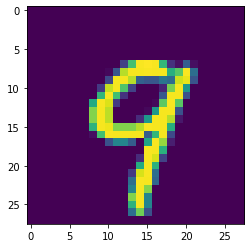

In [28]:
import codecs
import json

import matplotlib.pyplot as plt
import tensorflow as tf

HEIGHT = 28
WIDTH = 28
IMGNO = 12

mnist = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist
test_image = x_test[IMGNO]

jsondata = {"instances": [test_image.reshape(HEIGHT, WIDTH, 1).tolist()]}
json.dump(jsondata, codecs.open("test.json", "w", encoding="utf-8"))
plt.imshow(test_image.reshape(HEIGHT, WIDTH));

In [29]:
!cat test.json

{"instances": [[[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [

Finally, we can send it to the prediction service. The output will have a 1 in the index of the corresponding digit it is predicting. Congrats! You've completed the lab!

In [56]:
endpoint.resource_name

'projects/464686547413/locations/us-central1/endpoints/3359746894669545472'

In [64]:
%%bash
# ENDPOINT_RESOURCENAME= "3359746894669545472" # TODO: insert ENDPOINT_RESOURCENAME from above

gcloud ai endpoints predict "3359746894669545472" \
    --region=$REGION \
    --json-request=test.json

# gcloud ai endpoints predict "3359746894669545472" \ # $ENDPOINT_RESOURCENAME \
#     --region=$REGION \
#     --json-request=test.json

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]


Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]


In [46]:
endpoint.predict(instances=[test_image.reshape(HEIGHT, WIDTH, 1).tolist()])

Prediction(predictions=[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]], deployed_model_id='4684909094790758400', explanations=None)

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.